In [10]:
import json

# Load the labeled proposals (assumed to be in the JSON format as described)
proposal_file_path = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/labeled_proposals_resized.json'  # Update with the actual path
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)


In [72]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import os

class PotholeDatasetFromProposals(Dataset):
    def __init__(self, file_list, img_dir, proposals, transform=None):
        """
        Initialize the Pothole dataset using only the proposals JSON.
        
        Args:
            file_list (list): List of image filenames.
            img_dir (str): Directory where images are stored.
            proposals (dict): Proposed bounding boxes and labels for each image.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.file_list = file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform


        # Determine the target size if a Resize transform is provided
        new_size = None
        if transform is not None:
            for t in transform.transforms:
                if isinstance(t, T.Resize):
                    new_size = t.size  # Target size for resizing (height, width)

        self.new_size = new_size



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        
        # Load the image
        image = Image.open(image_path).convert("RGB")

        

        # Original size of the image
        original_size = (200, 200)  #NOTE: 200, 200 is just a placeholder - this should be the actual size of the image but it is a BUG in the code

        new_size = self.new_size
        # Scaling factors if Resize transform is applied
        if new_size:
            scale_x = new_size[0] / original_size[0]
            scale_y = new_size[1] / original_size[1]
        else:
            scale_x = scale_y = 1.0  # No resizing, so scaling factors are 1

        # Retrieve proposals for this image
        boxes = []
        labels = []
        for proposal in self.proposals.get(img_name, []):
            # Original bounding box coordinates
            x, y, width, height = (
                proposal["x_original"],
                proposal["y_original"],
                proposal["width_original"],
                proposal["height_original"],
            )

            # Scale bounding box coordinates
            x_resized = x * scale_x
            y_resized = y * scale_y
            width_resized = (x + width) * scale_x 
            height_resized = (y + height) * scale_y
            
            boxes.append([x_resized, y_resized, width_resized, height_resized])
            label = 0 if proposal['label'] == "background" else 1  # 0 for "background", 1 for "pothole"
            labels.append(label)        
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        
        # Apply transformation to the image if specified
        if self.transform:
            image = self.transform(image)
        
        # Prepare target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target


In [73]:
# Define image directory and list of image files based on proposal keys
img_dir = '/zhome/28/8/203659/UNI/Computer Vision DL/Segmentation/02516_poster_3/Potholes/annotated-images'
file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((500, 500)), # FOR NOW ALIGN WITH THE PROPOSALS, CHANGE DATALOADERS TO ALIGN WITH THE TRANSFORM
    T.ToTensor()
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    file_list=file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Example loop to access batched data
for images, targets in dataloader:
    print("Batch of images:", images)
    print("Batch of targets:", targets)
    break  # Display only the first batch


The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)


The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image wa

The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)


The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)The image was resized to (500, 500) from (200, 200)

The image was resized to (500, 500) from (200, 200)
The image was resized to (500, 500) from (200, 200)
The image wa

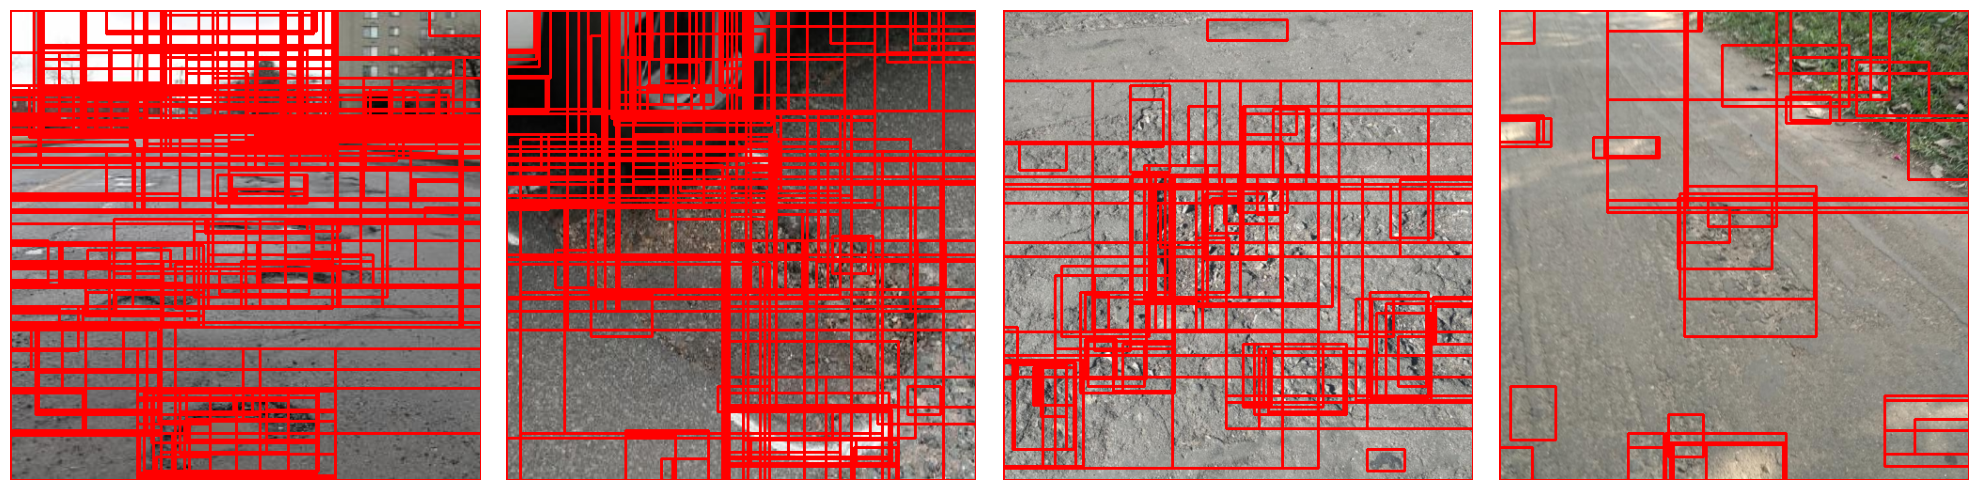

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_images(images, targets, denormalize=False):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    
    for i, (image, target) in enumerate(zip(images, targets)):
        #if image has any boxes that are not background
        if any([label != 0 for label in target['labels']]):
            continue
        
        # Convert image to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) and move to CPU if necessary
        if denormalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean  # Denormalize
            image = np.clip(image, 0, 1)  # Clip to [0, 1] range for display
        
        # Convert image to uint8 for OpenCV and plotting
        image = (image * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV compatibility
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw bounding boxes on the BGR image
        for box, label in zip(target['boxes'], target['labels']):
            # Convert box coordinates to numpy integers
            x_min, y_min, x_max, y_max = map(int, box)
            
            # Define color: red for background, blue for pothole
            color = (0, 0, 255) if label == 0 else (255, 0, 0)
            
            # Draw the rectangle on the image
            image_bgr = cv2.rectangle(image_bgr, (x_min, y_min), (x_max, y_max), color, 2)
        
        # Convert BGR image back to RGB for display in matplotlib
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        # Display the image
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first batch of images
images, targets = next(iter(dataloader))
plot_images(images, targets)


In [66]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.7  # 70% of the data for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Create indices for the dataset
dataset_size = len(dataset)
indices = list(range(dataset_size))

# First split: training set and remaining set
train_indices, temp_indices = train_test_split(indices, test_size=(1 - train_ratio), random_state=42)

# Second split: validation and test set from the remaining set
val_size = int(len(temp_indices) * (val_ratio / (val_ratio + test_ratio)))  # Adjust for remaining size
val_indices, test_indices = temp_indices[:val_size], temp_indices[val_size:]


In [67]:
from torch.utils.data import Subset

# Create subsets for train, validation, and test sets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


In [68]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
